# Introduction to Data Science 
# Lecture 14: Classification 2
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecutre, we'll discuss:
* decision trees
* generalizability and cross validation 

Recommended Reading: 
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Ch. 8 [digitial version available here](http://www-bcf.usc.edu/~gareth/ISL/)
* J. Grus, Data Science from Scratch, Ch.17
* [Visual Intro to Machine Learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)

This Lecture is in part based on [this lab](https://github.com/cs109/2015lab7/blob/master/Lab7-Botany%20and%20Ensemble%20Methods.ipynb) and [this blog](http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-29.html), as well as on the [scikit learn documentation](http://scikit-learn.org/stable/modules/tree.html).

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Classification

Recall that in *classification* we attempt to predict a categorical variable based on based on several features or attributes. 

We've already seen two methods for classification: 
1. Logistic Regression
+ k Nearest Neighbors (k-NN)

Today, we'll discuss: 
1. Decision Trees
+ Support Vector Machines

## Data

We'll consider [a dataset of Titanic passengers](https://www.kaggle.com/c/titanic/) and develop a model to predict whether a particular passenger will survive or not. This is what [the dataset](titanic.csv) looks like:


| PassengerId | *Survived* | Pclass | Name                                                                               | Sex    | Age  | SibSp | Parch | Ticket             | Fare     | Cabin           | Embarked |
|-------------|----------|--------|------------------------------------------------------------------------------------|--------|------|-------|-------|--------------------|----------|-----------------|----------|
| 1           | 0        | 3      | Braund, Mr. Owen Harris                                                            | male   | 22   | 1     | 0     | A/5 21171          | 7.25     |                 | S        |
| 2           | 1        | 1      | Cumings, Mrs. John Bradley (Florence Briggs Thayer)                                | female | 38   | 1     | 0     | PC 17599           | 71.2833  | C85             | C        |
| 3           | 1        | 3      | Heikkinen, Miss. Laina                                                             | female | 26   | 0     | 0     | STON/O2. 3101282   | 7.925    |                 | S        |
| 4           | 1        | 1      | Futrelle, Mrs. Jacques Heath (Lily May Peel)                                       | female | 35   | 1     | 0     | 113803             | 53.1     | C123            | S        |
| 5           | 0        | 3      | Allen, Mr. William Henry                                                           | male   | 35   | 0     | 0     | 373450             | 8.05     |                 | S        |


Here are the variable descriptions for the non-obvious variables:
 * **Survived:**        (0 = No; 1 = Yes)
 * **pclass:**          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
 * **sibsp:**           Number of Siblings/Spouses Aboard
 * **parch:**           Number of Parents/Children Aboard
 * **ticket:**          Ticket Number
 * **fare:**            Passenger Fare
 * **cabin:**           Cabin
 * **embarked:**        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


We're trying to decide whether a passenger with particular attributes will survive the Titanic disaster, so the **survival** variable is our label, the other columns are the **features**. 

We will **generate a model based on labeled data (hence "supervised learning")**, and ideally this model **should also work for new, similar data**. 

If a model satisfies this criterion, we say that it is **generalizable**. 

If a model has 100% accuracy on the training dataset but doesn't generalize to new data, then it isn't a very good model. We say that this model has **overfit** the data. 

The opposite of overfitting is **underfitting**, which happens when the model isn't complex enough to have good accuracy on the training dataset. 

**Cross-validation** is a general method for assessing how the results of a model (classification, regression,...) will *generalize* to an independent data set. 

In classification, cross-validation is a method for assessing how well the classification model will predict the class of points that weren't used to *train* the model. 

The idea of the method is simple: 
1. Split the dataset into two groups: the training dataset and the testing dataset. 
+ Train the model on the training dataset. 
+ Check the accuracy of the model on the testing dataset. 

In practice, you have to decide how to split the data into groups (i.e. how large the groups should be). You might also want to repeat the experiment so that the assessment doesn't depend on the way in which you split the data into groups.

## Decision Trees

[Decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning) are very intuitive classification and regression tools. Consider the following tree:

![Titanic Decision Tree](titanic_tree.png)

This tree predicts the survival of passengers on the titanic.  The figures under the leaves show the probability of survival and the percentage of observations in the leaf.

The use of a decision tree is very simple. Suppose someone gives you this tree and a new person. In order to predict whether or not the person would have died on the titanic, you ask the following questions, in order:

 * Is the person male? If no, we predict they would have survived. If yes, continue.
 * Is the person older than 9.5 years? If yes, we predict they would have died. If no, continue.
 * Did the person have more than 3 or more siblings? If yes, we predict they would have died. If no, they would have survived

The question we'll move to now is how would one build such a tree? 

## Building a Decision Tree

Building a decision tree isn't really much harder than reading one. Here's the essential rundown of the [ID3 algorithm](https://en.wikipedia.org/wiki/ID3_algorithm):

 * If the data all have the same label, create a leaf node that predicts that label, and you're done.
 * If the list of attributes is empty (e.g., because you have used all already), create a leaf node that predicts the most common label.
 * Else, partition the data by each of the attributes; choose the partition with the lowest error.
 * Recursively continue on each partitioned subset using the remaining attributes.
 * Terminate when no attributes are left (see above), or when desired depth or another termination criterion  is reached.
 
So, how do you choose the partition with the lowest error? There are various approaches.

Let's say we're building a classification tree by considering a list of predictors. In our example above we want to be able to classify whether people have survived based on things like gender, age, the booked fare, etc. Let's call the variables $X_{i,p}$ ($i$ for passengers, $p$ for predictors). Initially, for the first split, we consider all the passengers and all the predictors. We also have an observed label $Y_i$ for each passenger. 

We first assign everyone to the same class, say $\hat{Y}_i = 1$. We can calculate the *sum of squared residuals*, 
$$
SSR = \sum_i {(\hat{Y}_i - Y_i)^2}.
$$ 
We want to achieve two things: pick the **best split** for the **best predictor**.

- At **each step** of the algorithm we consider a list of possible decisions or splits, *e.g.*, $X_{i,6} > 9$ (age is greater than 9), or $X_{i,5} = female$.
- For each possible decision we recalculate the predictor for that rule, for example $\hat{Y}_i = 1$ if $X_{i,6} > 9$ and $0$ otherwise.
- We recalculate the error for each possible decision: $SSR = \sum_i {(\hat{Y}_i - Y_i)^2}$
- We choose the decision that reduces the error by the largest amount.
- Then continue with the next step on the reduced input set.

Alternative measures to SSR are the *Gini index* and *cross-entropy*, both measures of the total variance across the classes. 

In building decision trees, it is easy to overfit the data. There are several methods for avoiding this, which we'll discuss more below. Simple strategies inclue limiting the depth of a tree or only splitting when we have more than $N$ samples left. 

There is a very nice, [interactive tutorial on decision trees](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) that considers the problem of prediting whether a home is in *San Francisco* or *New York* based on attributes.
![](http://www.r2d3.us/static/pages/decision-trees-part-1/preview-en.png)

## Decision Trees with SciKit Learn

Scikit-learn has [a nice decision tree implementation](http://scikit-learn.org/stable/modules/tree.html) which we'll use to learn a tree for our Titanic dataset.

In [2]:
titanic = pd.read_csv("titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data cleanup

We need to do some cleanup: 
 * age has missing values, let's say wherever we have no value, we assume that the person is of mean age (this is not necessarily a good decision)
 * embarked has missing values, we add a dedicated category for unknown embarkation points
 * we need to convert the categorical values to numerical values 

In [3]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())

def sex_to_numeric(x):
    if x=='male':
        return 0
    if x=='female':
        return 1
    else:
        return x

titanic["Sex"] = titanic["Sex"].apply(sex_to_numeric)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# this will break if run more than once
def embarked_to_numeric(x):
    if x=="S":
        return 0
    if x=="C":
        return 1
    if x=="Q":
        return 2
    else: 
        return 3
    
titanic["Embarked"] = titanic["Embarked"].apply(embarked_to_numeric)
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,0
5,6,0,3,"Moran, Mr. James",0,29.699118,0,0,330877,8.4583,NaN,2
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.000000,0,0,17463,51.8625,E46,0
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.000000,3,1,349909,21.0750,NaN,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.000000,0,2,347742,11.1333,NaN,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.000000,1,0,237736,30.0708,NaN,1


Let's work only with the numerical and categorical variables and omit passengerID, Name, Ticket and Cabin. These values could contain some information, but it's hard to make sense of them without more context.

In [5]:
features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
titanic = titanic[features]
titanic.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7.2500,0
1,1,1,1,38.000000,1,0,71.2833,1
2,1,3,1,26.000000,0,0,7.9250,0
3,1,1,1,35.000000,1,0,53.1000,0
4,0,3,0,35.000000,0,0,8.0500,0
5,0,3,0,29.699118,0,0,8.4583,2
6,0,1,0,54.000000,0,0,51.8625,0
7,0,3,0,2.000000,3,1,21.0750,0
8,1,3,1,27.000000,0,2,11.1333,0
9,1,2,1,14.000000,1,0,30.0708,1


## Exploring the data

Let's take a look at the data:

In [6]:
titanic.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.368126
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.647601
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000


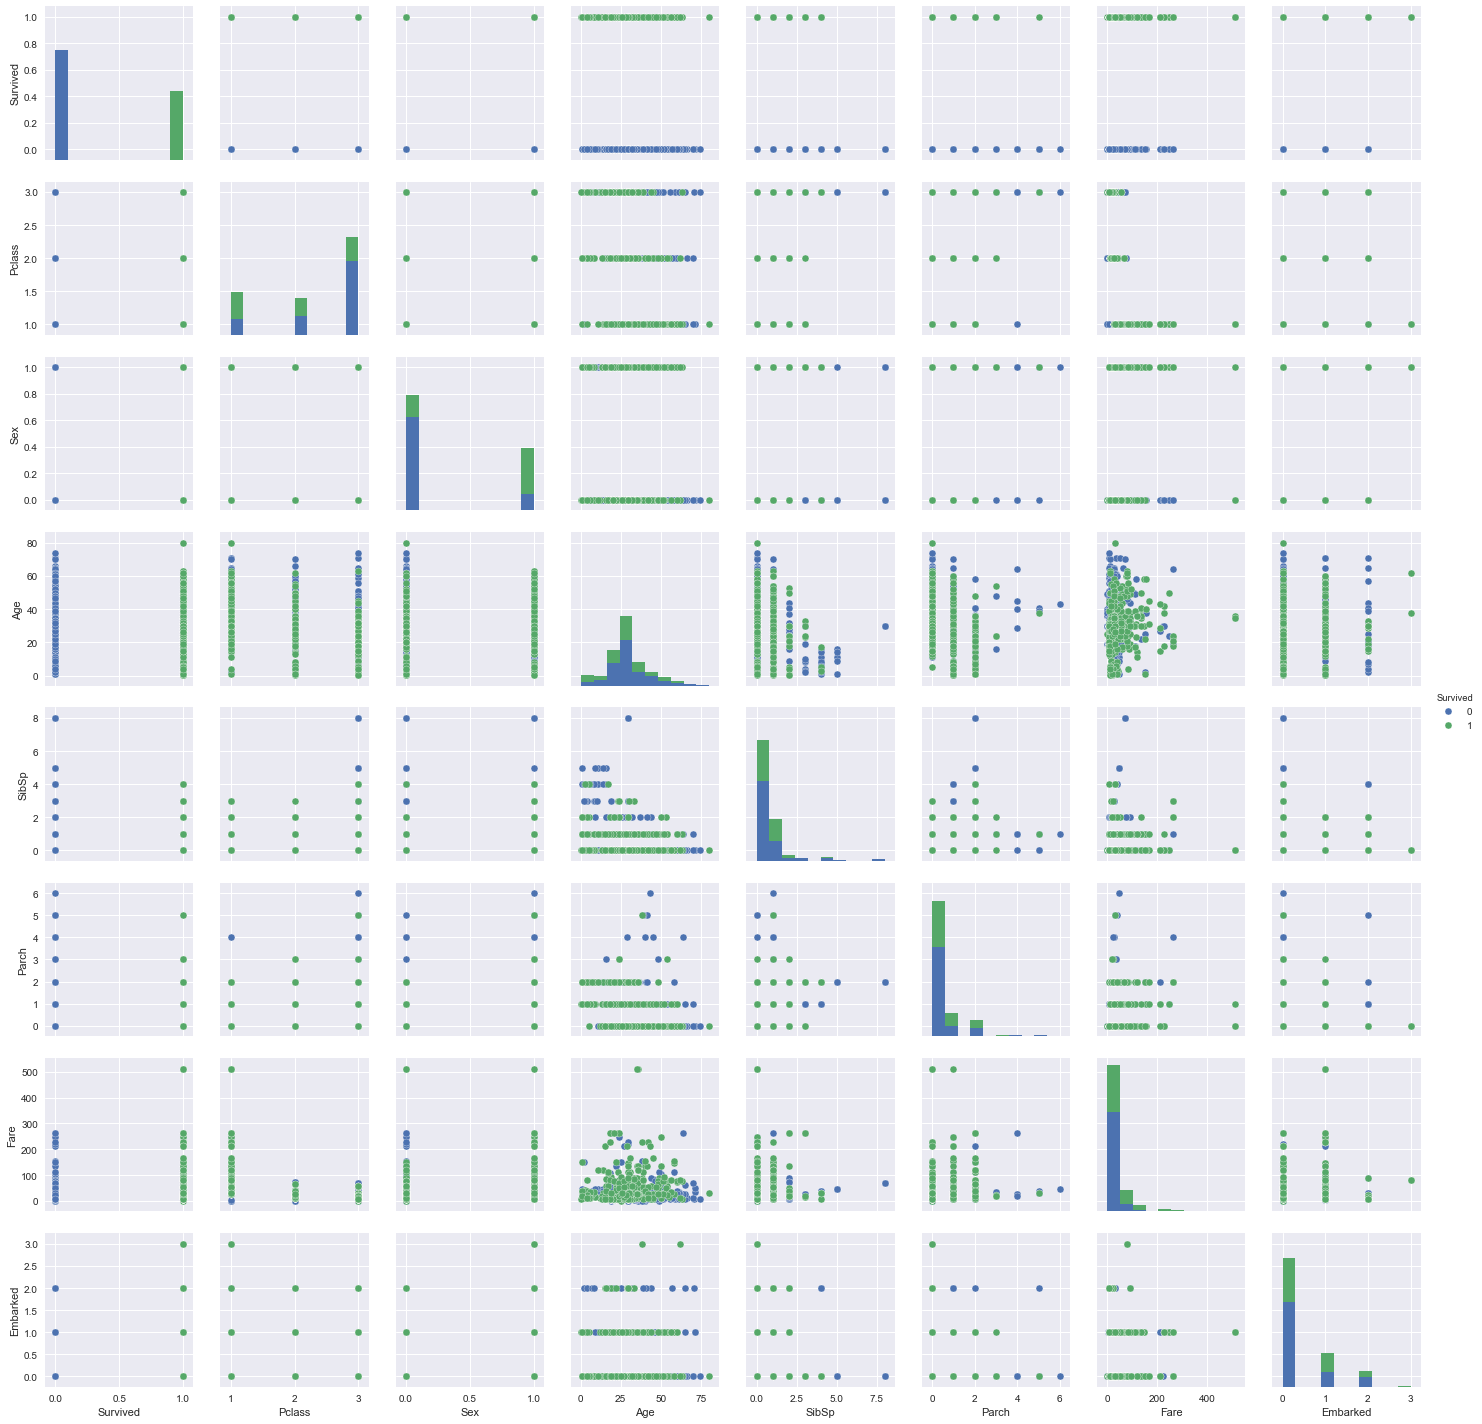

In [7]:
import seaborn as sns
sns.set()
sns.pairplot(titanic, hue="Survived");

It's difficult to find clear patterns here, except for the histogram that separates Sex.


## Our first tree
Here is some code that splits the data into training and test sets for cross-validation and selects features.

In [8]:
labels =["Survived", "Perished"]

def splitData(features):
    titanic_predictors = titanic[features].as_matrix()
    titanic_labels = titanic["Survived"].as_matrix()

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(titanic_predictors, titanic_labels, random_state=1, test_size=0.5)
    return XTrain, XTest, yTrain, yTest

And more code for plotting decision trees:

In [9]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Perished", "Survived"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

Now let's look at a decision tree that **ONLY operates on sex**! 

Accuracy on training data =  0.811235955056
Accuracy on test data =  0.762331838565


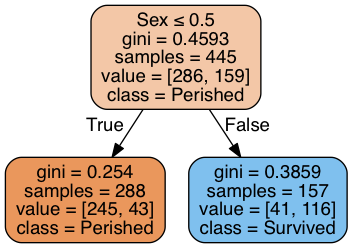

In [10]:
decisionTree = tree.DecisionTreeClassifier()

XTrain, XTest, yTrain, yTest = splitData(["Sex"])
# fit the tree with the traing data
decisionTree = decisionTree.fit(XTrain, yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(XTrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(XTest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

renderTree(decisionTree, ["Sex"])

~76% correct on the test set isn't bad! - sex seems to be a very good indicator of whether someone has survived or not.

Let's add more features.

## Adding more features

Accuracy on training data=  0.833707865169
Accuracy on test data=  0.760089686099


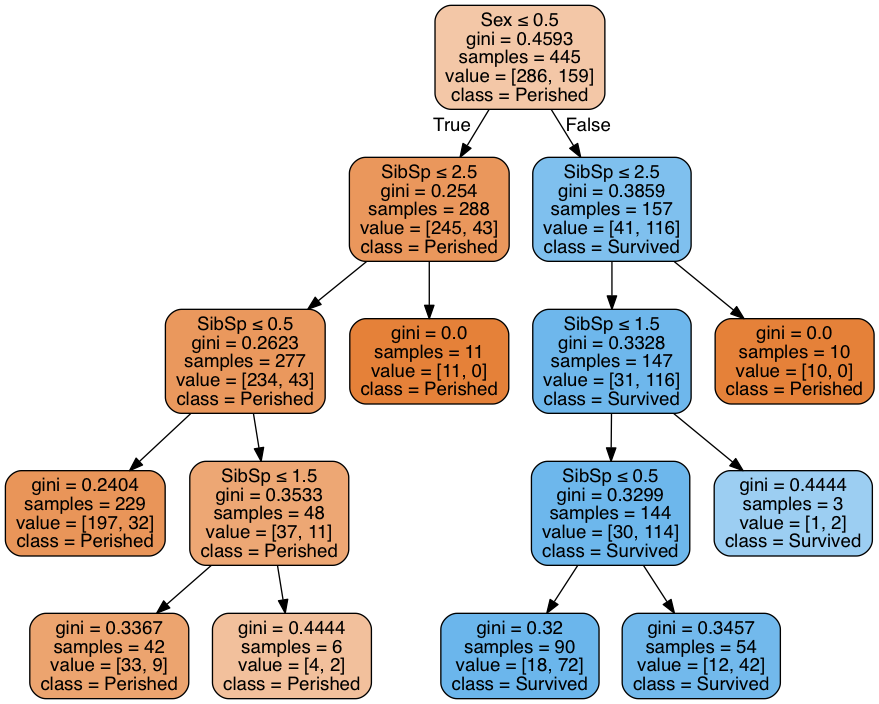

In [11]:
#  train tree on sex and the number of the number of siblings/spouses aboard
used_features = ["Sex", "SibSp"]
XTrain, XTest, yTrain, yTest = splitData(used_features)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, used_features)

Our accuracy on the training data has gone up, but the accuracy on the test data has gone down. It looks like we're overfitting. But maybe we just selected the wrong features? Let's just try all of them! 

In [12]:
all_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

XTrain, XTest, yTrain, yTest = splitData(all_features)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
# renderTree(decisionTree, all_features)

Accuracy on training data=  0.988764044944
Accuracy on test data=  0.757847533632


OK, clearly, we're overfitting the data - 98% accuracy on the training data and only ~75% on the test data. Yet, we've created a complicated tree. 

Decision trees are notorious for overfitting the data. There are two parameters that help us reign in overfitting:

* **max_depth:** The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* **min_samples_split:** The minimum number of samples required to split an internal node: If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a percentage and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

Let's try combinations of depth and min split size:

Accuracy on training data=  0.862921348315
Accuracy on test data=  0.793721973094


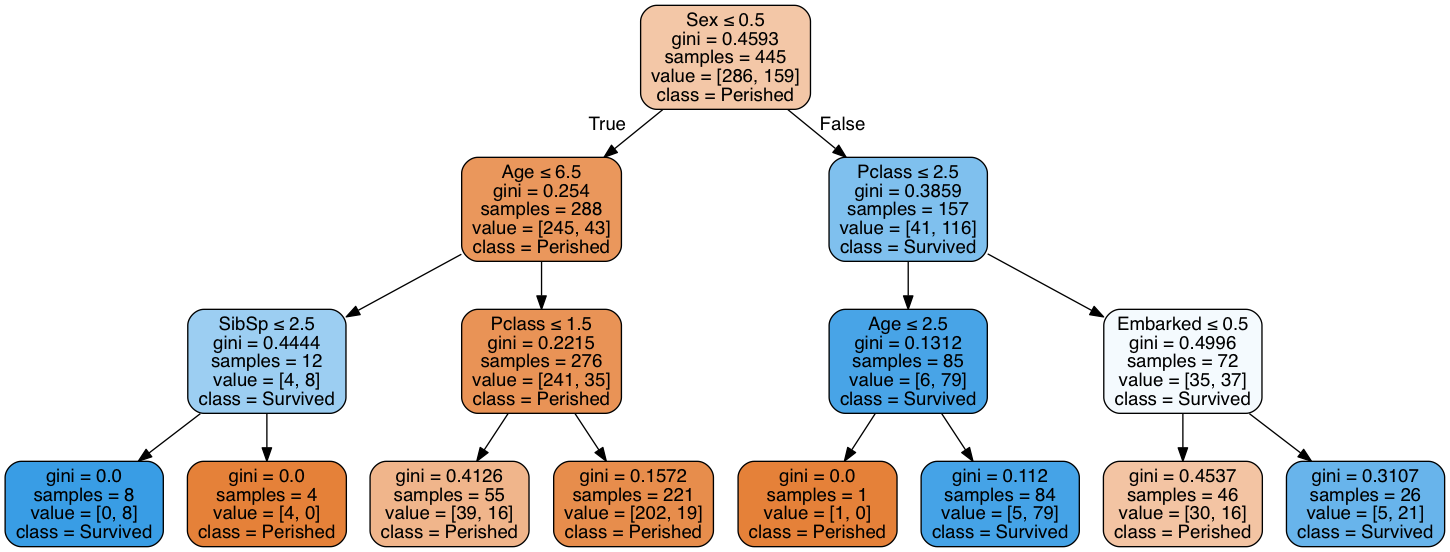

In [13]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Accuracy on training data=  0.894382022472
Accuracy on test data=  0.775784753363


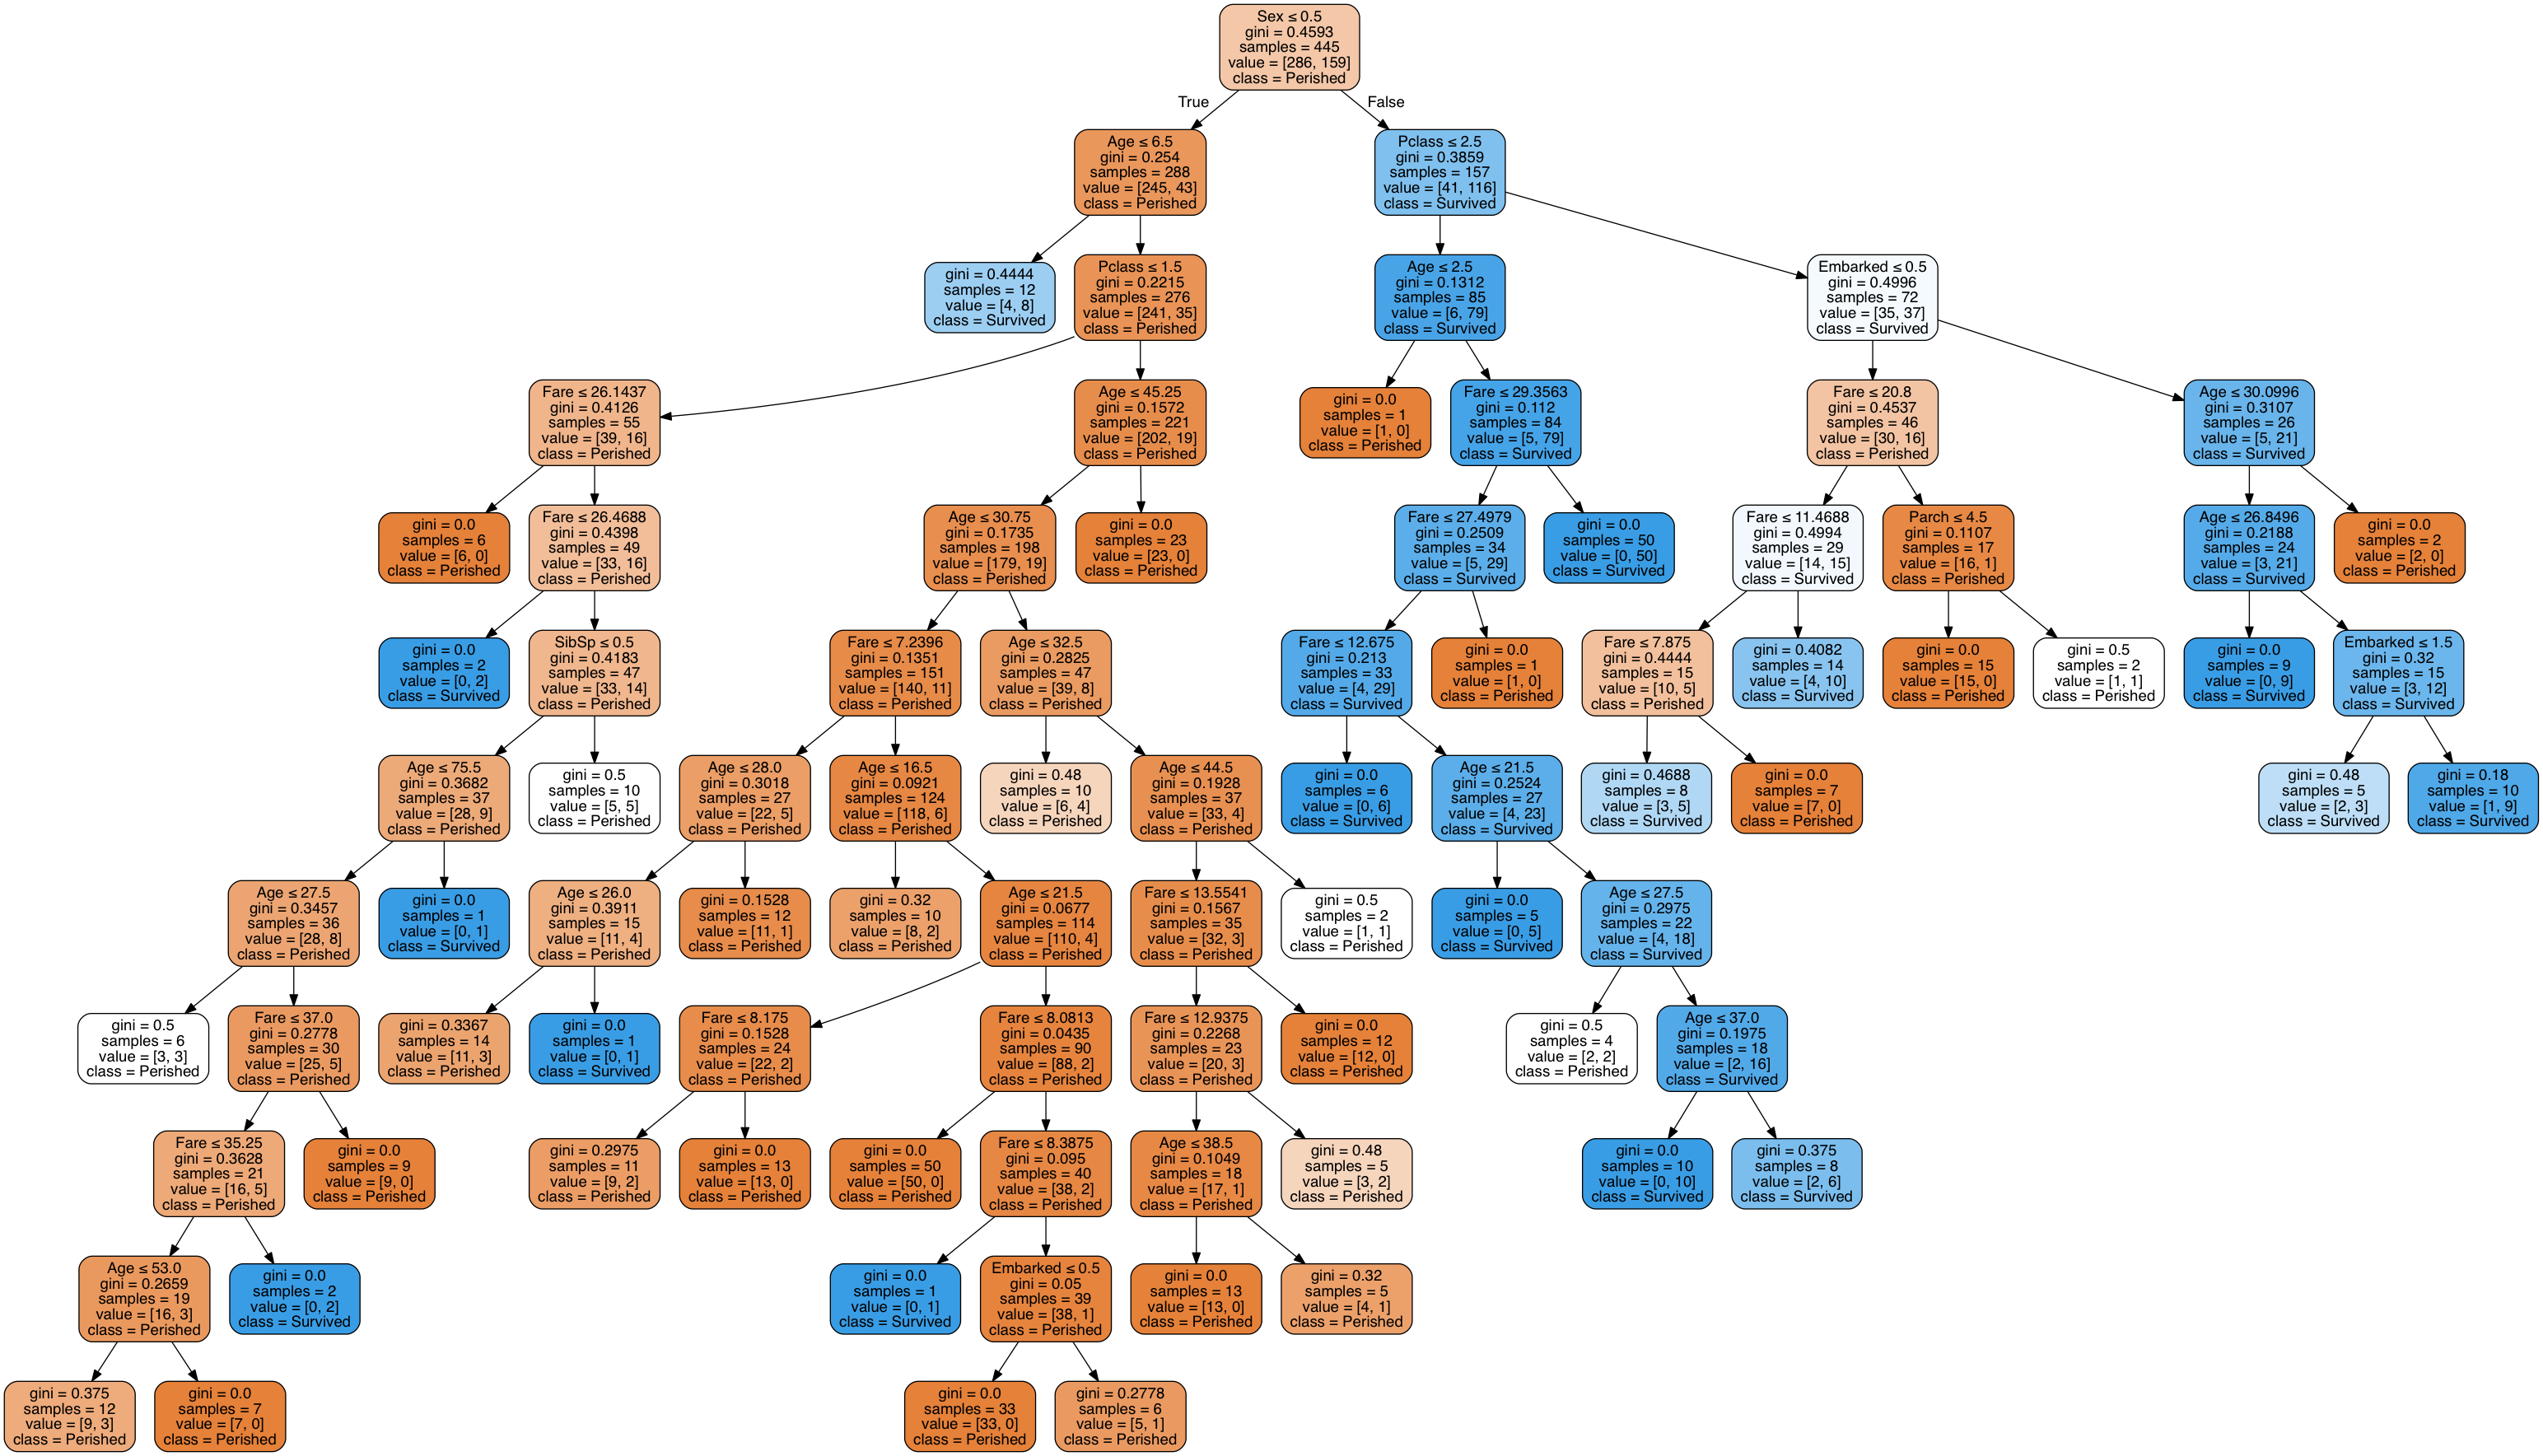

In [14]:
decisionTree = tree.DecisionTreeClassifier(min_samples_split=15)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Accuracy on training data=  0.862921348315
Accuracy on test data=  0.793721973094


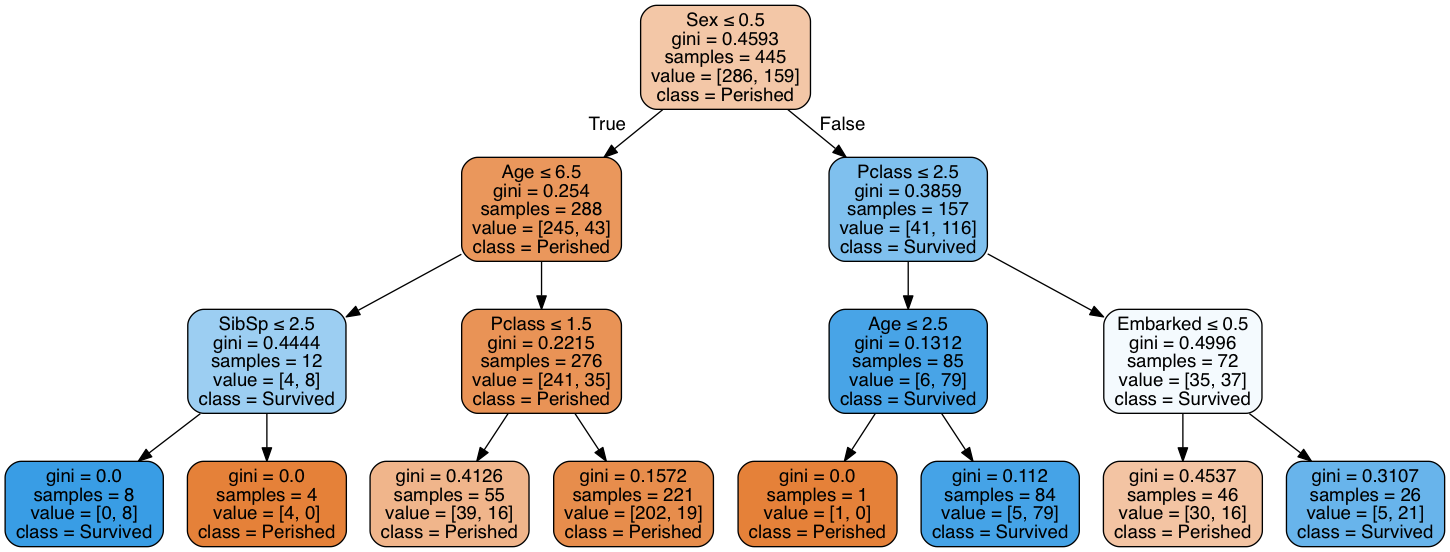

In [15]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3, min_samples_split=10)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

It looks like both, the minimum number of samples for splitting and the maximum depth help with overfitting and we achieve a 79-80% accuracy rate. That doesn't sound much better than just gender alone, but 4% improvement is a lot in classification. Also, in the last combination we have a pretty simple model. The main point seems to be:

 * Sex is the dominant factor at the root of the tree
 * For females, if you're in class 1 or 2 you're almost sure to survive
 * For males, if you were younger than 6.5 years old, you had a chance to survive. 
 * Also note that there are branches that predict the same thing, but with different certainty. For example, in the male / adult category, if you were in "first class", you still were likely to die, but less likely than in second or third. 

## Discussion 

### Advantages of decision trees
* Decision trees are simple to explain and interpret
* There is a nice graphical display for trees
* Easy to hand categorial predictors (no dummy variables needed)

### Disadvantages of decision trees
* Decision trees generally don't have the predicitve accuracy of other approaches as they tend to overfit the data. 
* Decision trees are non-robust, *i.e.*, sensitive to small changes in the data.

Both of these disadvantages are addressed by the following, more advanced methods. 

### Extensions of decision trees: Bagging, Random Forests, and Boosting

* **Bagging.** The idea of [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) is to generate several decision trees based on subsets of the data and let the decision trees vote to arrive at a prediciton. Since averaging a set of observations reduces variances (think CLT), this increases the predictive accuracy of the method. 

* **Random Forests.** Another way to counteract overfitting, called [Random Forests](https://en.wikipedia.org/wiki/Random_forest), is to combine multiple decision trees that were generated with some randomness and let them vote on the result. Here the randomness comes from choosing a random sample of the prediction variables to build each tree. 

* **Boosting.** [Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning) is similiar to bagging, except that the trees are grown sequentially.  

These extensions are examples of *ensemble learning*, as they combines multiple learning algorithms. You can read a little about such methods in ISL, Ch. 8.